In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
%matplotlib inline


# K Nearest Neighbors

In [2]:
data1 = pd.read_csv('project3_dataset1.txt', sep = '\t', header = None)
data2 = pd.read_csv('project3_dataset2.txt', sep = '\t', header = None)

In [3]:
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637,1
1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.52490,0.53550,0.17410,0.3985,0.12440,1
2,11.26,19.96,73.72,394.1,0.08020,0.11810,0.09274,0.05588,0.2595,0.06233,...,22.33,78.27,437.6,0.1028,0.18430,0.15460,0.09314,0.2955,0.07009,0
3,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.02875,0.1734,0.05865,...,22.02,79.93,462.0,0.1190,0.16480,0.13990,0.08476,0.2676,0.06765,0
4,14.61,15.69,92.68,664.9,0.07618,0.03515,0.01447,0.01877,0.1632,0.05255,...,21.75,103.70,840.8,0.1011,0.07087,0.04746,0.05813,0.2530,0.05695,0


In [4]:
data2.head()

,0,1,2,3,4,5,6,7,8,9
0,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0
1,123,0.05,4.61,13.69,Absent,51,23.23,2.78,16,0
2,128,0.50,3.70,12.81,Present,66,21.25,22.73,28,0
3,114,9.60,2.51,29.18,Absent,49,25.67,40.63,46,0
4,150,0.30,6.38,33.99,Present,62,24.64,0.00,50,0


In [5]:
# column 4 needs to be converted to numerical 1 if present, 0 if absent
data2[4] = data2[4].map({'Present': 1, 'Absent': 0})

In [6]:
data1_X = data1.iloc[:,:30]
data1_y = data1.iloc[:,30]

data2_X = data2.iloc[:,:9]
data2_y = data2.iloc[:,9]

## dataset 1

In [7]:
X1_train, X1_test, y1_train, y1_test = train_test_split(data1_X, data1_y, test_size=0.2, random_state=42)

In [8]:
n_naybs = [*range(1, 50, 1)]

params = [{'n_neighbors' : n_naybs}]
scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

neigh_gs = KNeighborsClassifier()

In [9]:
t = time.time()

gs_neigh = GridSearchCV(estimator = neigh_gs,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_neigh.fit(X1_train, y1_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_neigh.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')


Fitting 10 folds for each of 49 candidates, totalling 490 fits
The best parameters found are:  {'n_neighbors': 9}
The optimal parameters were found in : 18.26598596572876  seconds


In [10]:
test_scores = list(gs_neigh.cv_results_['mean_test_accuracy'])
train_scores = list(gs_neigh.cv_results_['mean_train_accuracy'])
layer_num = list(gs_neigh.cv_results_['param_n_neighbors'].data)

In [11]:
results = gs_neigh.cv_results_

In [14]:
heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['n_neighbors'] = layer_num
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]


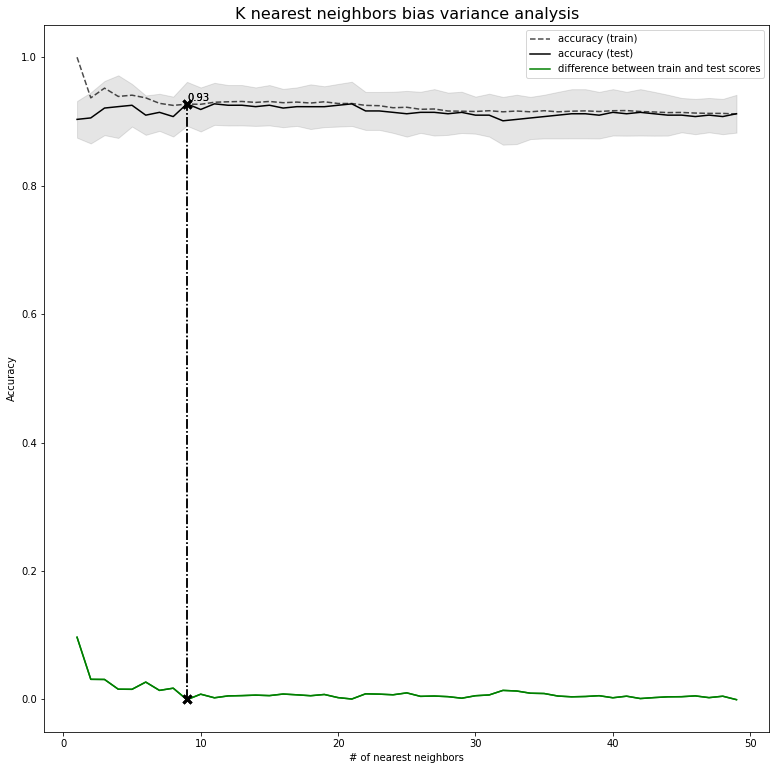

In [15]:

# this piece of code was adapted from sklearn website for multimetric ploting
plt.figure(figsize=(13, 13))
plt.title("K nearest neighbors bias variance analysis", fontsize=16)

plt.xlabel("# of nearest neighbors")
plt.ylabel("Accuracy")

ax = plt.gca()
#ax.set_xlim(0, 52)
#ax.set_ylim(0.75, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_neighbors"].data, dtype=float)

acc = scoring['accuracy']
scorer = 'accuracy'
for sample, style in (("train", "--"), ("test", "-")):
    sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
    sample_score_std = results["std_%s_%s" % (sample, scorer)]
    ax.fill_between(
        X_axis,
        sample_score_mean - sample_score_std,
        sample_score_mean + sample_score_std,
        alpha=0.1 if sample == "test" else 0,
        color=color,
    )
    ax.plot(
        X_axis,
        sample_score_mean,
        style,
        color=color,
        alpha=1 if sample == "test" else 0.7,
        label="%s (%s)" % (scorer, sample),
    )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]
    ax.plot(
        X_axis,
        diff, 
        color = 'g',
        label = 'difference between train and test scores' if sample == 'test' else '')
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()


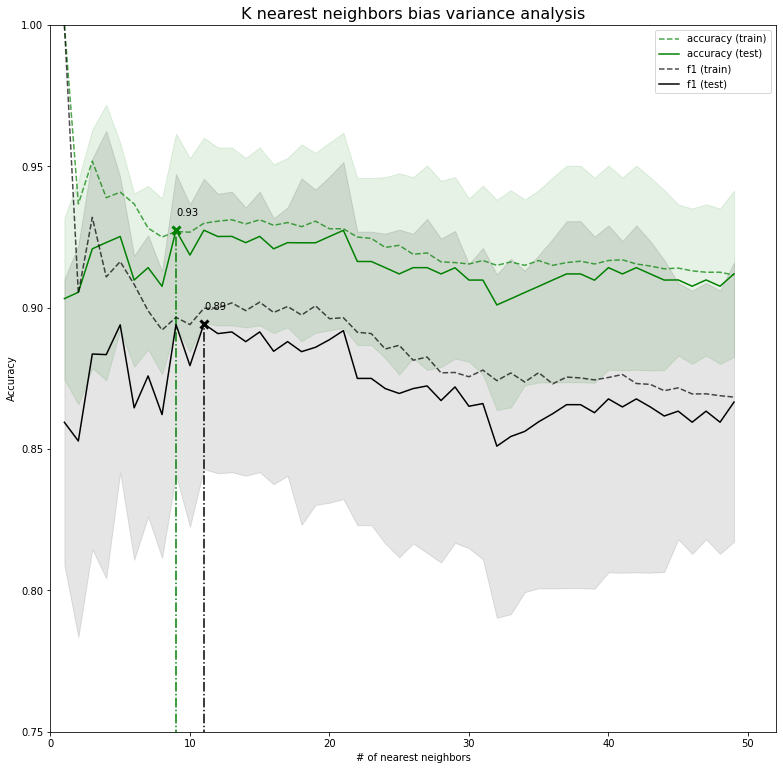

In [16]:
# this piece of code was adapted from sklearn website for multimetric ploting
plt.figure(figsize=(13, 13))
plt.title("K nearest neighbors bias variance analysis", fontsize=16)

plt.xlabel("# of nearest neighbors")
plt.ylabel("Accuracy")

ax = plt.gca()
ax.set_xlim(0, 52)
ax.set_ylim(0.75, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_neighbors"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### based on accuracy, the best parameters are KNN = 9
### I'll retrain on all training data and give the test accuracy now

In [17]:
final_model = KNeighborsClassifier(n_neighbors = 9)
final_model.fit(X1_train, y1_train)
train_scores = cross_validate(final_model, X1_train, y1_train, cv=10, scoring=scoring_metrics)
predictions1 = final_model.predict(X1_test)

In [18]:
data = [["Mean score of 10 fold CV on training set\n", np.mean(train_scores['test_accuracy']), np.mean(train_scores['test_precision']), np.mean(train_scores['test_recall']),
         np.mean(train_scores['test_f1']), np.mean(train_scores['test_roc_auc'])], 
         ["Test Scores", sklearn.metrics.accuracy_score(y1_test, predictions1), sklearn.metrics.precision_score(y1_test, predictions1), 
        sklearn.metrics.recall_score(y1_test, predictions1), sklearn.metrics.f1_score(y1_test, predictions1),
          sklearn.metrics.roc_auc_score(y1_test, predictions1)]]
print(tabulate(data, headers=["Accuracy", "Precision", "Recall", "F1", "AUC"]))

                                            Accuracy    Precision    Recall        F1       AUC
----------------------------------------  ----------  -----------  --------  --------  --------
Mean score of 10 fold CV on training set    0.92744      0.945313  0.854779  0.894091  0.967267
Test Scores                                 0.947368     1         0.869565  0.930233  0.934783


In [19]:
data = [['Accuracy', np.mean(train_scores['test_accuracy']), sklearn.metrics.accuracy_score(y1_test, predictions1)],
['Precision', np.mean(train_scores['test_precision']),sklearn.metrics.precision_score(y1_test, predictions1)],
['Recall', np.mean(train_scores['test_recall']), sklearn.metrics.recall_score(y1_test, predictions1)],
['F1', np.mean(train_scores['test_f1']), sklearn.metrics.f1_score(y1_test, predictions1)],
['AUC', np.mean(train_scores['test_roc_auc']), sklearn.metrics.roc_auc_score(y1_test, predictions1)]]
print (tabulate(data, headers=["metric", "Mean score of 10 fold cross validation on training set", "Test Scores"]))

metric       Mean score of 10 fold cross validation on training set    Test Scores
---------  --------------------------------------------------------  -------------
Accuracy                                                   0.92744        0.947368
Precision                                                  0.945313       1
Recall                                                     0.854779       0.869565
F1                                                         0.894091       0.930233
AUC                                                        0.967267       0.934783


## dataset 2

In [20]:
X2_train, X2_test, y2_train, y2_test = train_test_split(data2_X, data2_y, test_size=0.2, random_state=42)

In [21]:
n_naybs = [*range(1, 50, 1)]

params = [{'n_neighbors' : n_naybs}]
scoring = { "accuracy": make_scorer(accuracy_score), "precision": "precision", "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

scoring_metrics = ['accuracy', 'precision', 'recall','f1','roc_auc']

neigh_gs = KNeighborsClassifier()

In [22]:
t = time.time()

gs_neigh = GridSearchCV(estimator = neigh_gs,
                      param_grid=params,
                      scoring=scoring_metrics,
                      cv=10,
                        verbose = 1,
                        refit="accuracy",
                        return_train_score=True)

gs_neigh.fit(X2_train, y2_train)

elapsed = time.time() - t
print('The best parameters found are: ', gs_neigh.best_params_)
print('The optimal parameters were found in :', elapsed, ' seconds')


Fitting 10 folds for each of 49 candidates, totalling 490 fits
The best parameters found are:  {'n_neighbors': 47}
The optimal parameters were found in : 12.166889905929565  seconds


In [24]:
test_scores = list(gs_neigh.cv_results_['mean_test_accuracy'])
train_scores = list(gs_neigh.cv_results_['mean_train_accuracy'])
layer_num = list(gs_neigh.cv_results_['param_n_neighbors'].data)

In [25]:
results = gs_neigh.cv_results_
heatmap_scores = pd.DataFrame()
heatmap_scores['train accuracy'] = train_scores
heatmap_scores['test accuracy'] = test_scores
heatmap_scores['n_neighbors'] = layer_num
diff = [train_score - test_score for train_score, test_score in zip(train_scores, test_scores)]

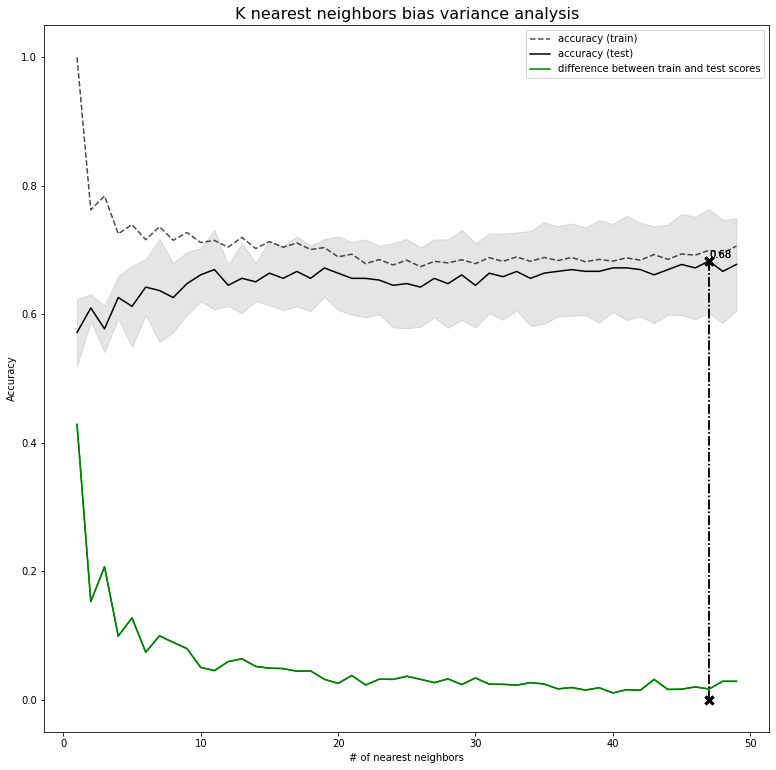

In [26]:

# this piece of code was adapted from sklearn website for multimetric ploting
plt.figure(figsize=(13, 13))
plt.title("K nearest neighbors bias variance analysis", fontsize=16)

plt.xlabel("# of nearest neighbors")
plt.ylabel("Accuracy")

ax = plt.gca()
#ax.set_xlim(0, 52)
#ax.set_ylim(0.75, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_neighbors"].data, dtype=float)

acc = scoring['accuracy']
scorer = 'accuracy'
for sample, style in (("train", "--"), ("test", "-")):
    sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
    sample_score_std = results["std_%s_%s" % (sample, scorer)]
    ax.fill_between(
        X_axis,
        sample_score_mean - sample_score_std,
        sample_score_mean + sample_score_std,
        alpha=0.1 if sample == "test" else 0,
        color=color,
    )
    ax.plot(
        X_axis,
        sample_score_mean,
        style,
        color=color,
        alpha=1 if sample == "test" else 0.7,
        label="%s (%s)" % (scorer, sample),
    )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]
    ax.plot(
        X_axis,
        diff, 
        color = 'g',
        label = 'difference between train and test scores' if sample == 'test' else '')
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()



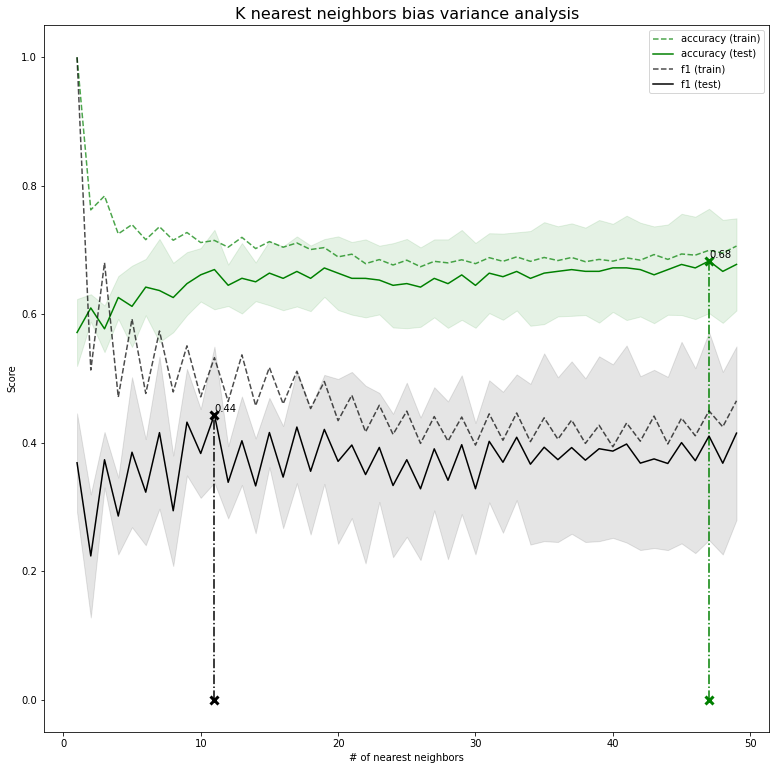

In [27]:
# this piece of code was adapted from sklearn website for multimetric ploting
plt.figure(figsize=(13, 13))
plt.title("K nearest neighbors bias variance analysis", fontsize=16)

plt.xlabel("# of nearest neighbors")
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 52)
#ax.set_ylim(0.75, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_neighbors"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()


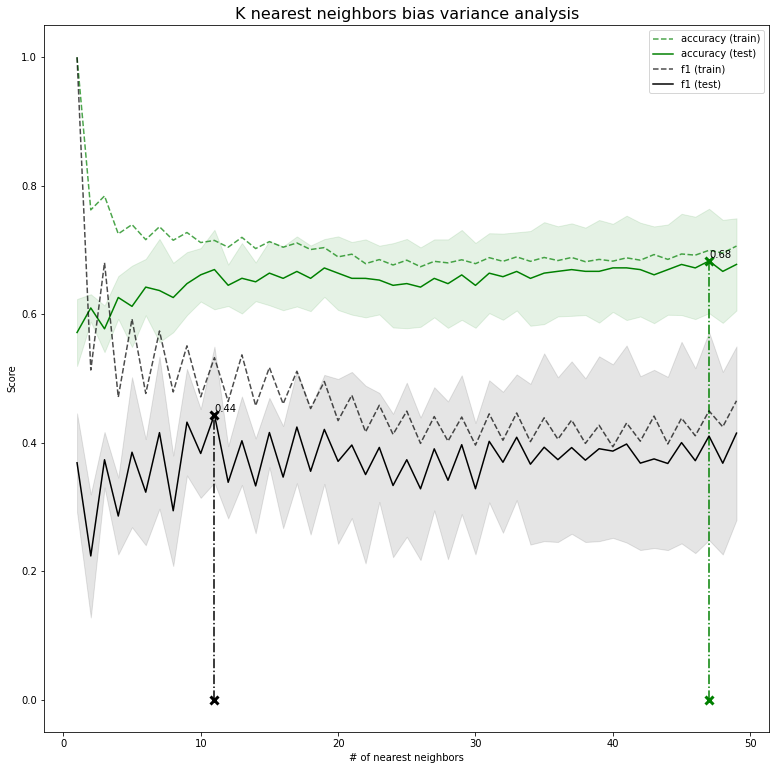

In [50]:
# this piece of code was adapted from sklearn website for multimetric ploting
plt.figure(figsize=(13, 13))
plt.title("K nearest neighbors bias variance analysis", fontsize=16)

plt.xlabel("# of nearest neighbors")
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 52)
#ax.set_ylim(0.75, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_neighbors"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

## based on accuracy, the best parameters are KNN = 47
## I'll retrain on all training data and give the test accuracy now

In [28]:
final_model = KNeighborsClassifier(n_neighbors = 47)
final_model.fit(X2_train, y2_train)
train_scores = cross_validate(final_model, X2_train, y2_train, cv=10, scoring=scoring_metrics)
predictions2 = final_model.predict(X2_test)

In [29]:
data = [["Mean score of 10 fold CV on training set\n", np.mean(train_scores['test_accuracy']), np.mean(train_scores['test_precision']), np.mean(train_scores['test_recall']),
         np.mean(train_scores['test_f1']), np.mean(train_scores['test_roc_auc'])], 
         ["Test Scores", sklearn.metrics.accuracy_score(y2_test, predictions2), sklearn.metrics.precision_score(y2_test, predictions2), 
        sklearn.metrics.recall_score(y2_test, predictions2), sklearn.metrics.f1_score(y2_test, predictions2),
          sklearn.metrics.roc_auc_score(y2_test, predictions2)]]
print(tabulate(data, headers=["Accuracy", "Precision", "Recall", "F1", "AUC"]))

                                            Accuracy    Precision    Recall        F1       AUC
----------------------------------------  ----------  -----------  --------  --------  --------
Mean score of 10 fold CV on training set    0.682883     0.64246   0.315385  0.410354  0.728511
Test Scores                                 0.688172     0.411765  0.269231  0.325581  0.559989


In [30]:
data = [['Accuracy', np.mean(train_scores['test_accuracy']), sklearn.metrics.accuracy_score(y2_test, predictions2)],
['Precision', np.mean(train_scores['test_precision']),sklearn.metrics.precision_score(y2_test, predictions2)],
['Recall', np.mean(train_scores['test_recall']), sklearn.metrics.recall_score(y2_test, predictions2)],
['F1', np.mean(train_scores['test_f1']), sklearn.metrics.f1_score(y2_test, predictions2)],
['AUC', np.mean(train_scores['test_roc_auc']), sklearn.metrics.roc_auc_score(y2_test, predictions2)]]
print (tabulate(data, headers=["metric", "Mean score of 10 fold cross validation on training set", "Test Scores"]))

metric       Mean score of 10 fold cross validation on training set    Test Scores
---------  --------------------------------------------------------  -------------
Accuracy                                                   0.682883       0.688172
Precision                                                  0.64246        0.411765
Recall                                                     0.315385       0.269231
F1                                                         0.410354       0.325581
AUC                                                        0.728511       0.559989
